<a href="https://colab.research.google.com/github/LennonLab/sporeAI/blob/dylan/cellSAM2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CellSAM segmentation model

In [ ]:
# have to run the below command for every new colab session
!pip install git+https://github.com/vanvalenlab/cellSAM.git

  Cloning https://github.com/vanvalenlab/cellSAM.git to /tmp/pip-req-build-51vsh81q
  Running command git clone --filter=blob:none --quiet https://github.com/vanvalenlab/cellSAM.git /tmp/pip-req-build-51vsh81q
  Resolved https://github.com/vanvalenlab/cellSAM.git to commit a392cdd199eebd11646cf6dd115a992af33f6365
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-install-pfgkn3mz/segment-anything_dbf7a059c5664f69b5512d798d5e45f1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-install-pfgkn3mz/segment-anything_dbf7a059c5664f69b5512d798d5e45f1
  Resolved https://github.com/facebookresearch/segment-anything.git to commit dca509fe793f601edb92606367a655c15ac00fdf
  Preparing metadata (setup.py) ... done


In [ ]:
from cellSAM import segment_cellular_image, get_model
import numpy as np
import torch
import matplotlib.pyplot as plt
from skimage import io
from skimage.exposure import adjust_gamma
import scipy.ndimage as ndi
%matplotlib inline

In [ ]:
def sidebyside(img1, img2, title1='', title2=''):
  fig, axes = plt.subplots(1,2, figsize=(16,16))

  # image 1
  axes[0].imshow(img1)
  axes[0].set_title(title1)

  # image 2
  axes[1].imshow(img2)
  axes[1].set_title(title2)

  plt.show()

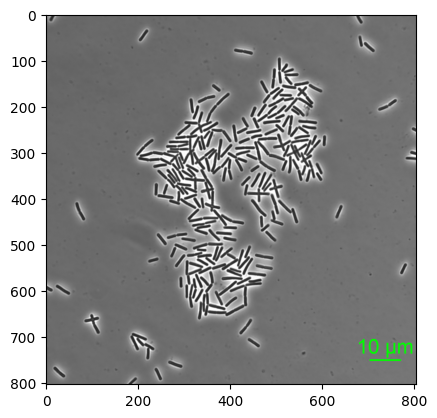

In [ ]:
imgpath = "20240917_delta6_100x_1.tif"
img = io.imread(imgpath)
img = cv2.resize(img, (0,0), fx=0.5, fy=0.5)
plt.imshow(img)

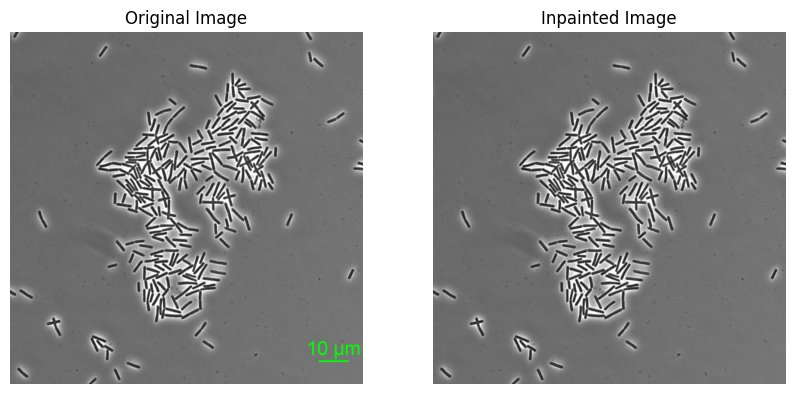

In [ ]:
# section to remove 10 um from image
def InpaintImage(img):
  mask = (img[:,:,0] != img[:,:,1]) | (img[:,:,0] != img[:,:,2])
  mask = mask.astype(np.uint8) * 255

  inpainted = cv2.inpaint(img, mask, inpaintRadius=5, flags=cv2.INPAINT_TELEA)
  return inpainted

# mask = (img[:,:,0] != img[:,:,1]) | (img[:,:,0] != img[:,:,2])
# mask = mask.astype(np.uint8) * 255

img_2 = InpaintImage(img)

# Display the result
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title("Original Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.subplot(1, 2, 2)
plt.title("Inpainted Image")
plt.axis('off')
plt.imshow(cv2.cvtColor(img_2, cv2.COLOR_BGR2RGB))
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

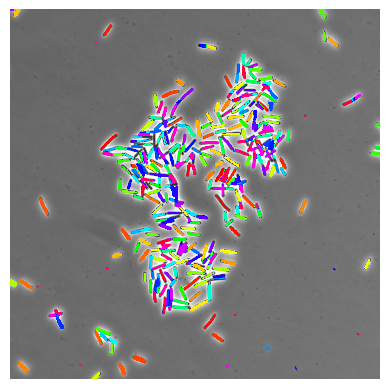

In [ ]:
# Segmentation using cellSAM

# Run segmentation of img
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# bbox_threshold parameter is threshold for bounding box confidence
## lower values improves selection
mask, embedding, bounding_boxes = segment_cellular_image(img_2,
                                                         device=str(device),
                                                         bbox_threshold = 0.14)
# Create a masked array from mas
colored_mask = np.ma.masked_where(mask==0, mask)

plt.imshow(img_2)
plt.imshow(colored_mask, cmap='hsv')
plt.axis('off')
plt.show

# Process in quadrants

In [ ]:
def remove_smalls(mask):
  values, counts = np.unique(mask, return_counts=True)

  values_to_keep = values[counts >= 400]

  mask[~np.isin(mask, values_to_keep)] = 0

  return mask

In [ ]:
def preprocess(image):
  img = image.copy()
  img = ndi.filters.gaussian_filter(img, sigma=1)
  img = adjust_gamma(img, gamma=1, gain=1)
  return img

In [ ]:
def Quadrants(image):
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  h, w, _ = img.shape
  half_h, half_w = h//2, w//2

  tl = preprocess(img[:half_h, :half_w])
  tr = preprocess(img[:half_h, half_w:])
  bl = preprocess(img[half_h:, :half_w])
  br = preprocess(img[half_h:, half_w:])

  tl_mask, _, _ = segment_cellular_image(tl, device=str(device), bbox_threshold=0.2)
  tl_mask = remove_smalls(tl_mask)
  tr_mask, _, _ = segment_cellular_image(tr, device=str(device), bbox_threshold=0.2)
  tr_mask = remove_smalls(tr_mask)
  bl_mask, _, _ = segment_cellular_image(bl, device=str(device), bbox_threshold=0.2)
  bl_mask = remove_smalls(bl_mask)
  br_mask, _, _ = segment_cellular_image(br, device=str(device), bbox_threshold=0.2)
  br_mask = remove_smalls(br_mask)

  top_mask = np.concatenate((tl_mask, tr_mask), axis=1)
  bottom_mask = np.concatenate((bl_mask, br_mask), axis=1)
  return np.concatenate((top_mask, bottom_mask), axis=0)

In [ ]:
imgpath = "20240917_delta6_100x_1.tif"
img = io.imread(imgpath)
img = InpaintImage(img)

In [ ]:
quadmask = Quadrants(img)

<ipython-input-276-2094386839a3>:3: DeprecationWarning: Please import `gaussian_filter` from the `scipy.ndimage` namespace; the `scipy.ndimage.filters` namespace is deprecated and will be removed in SciPy 2.0.0.
  img = ndi.filters.gaussian_filter(img, sigma=1)


<function matplotlib.pyplot.show(close=None, block=None)>

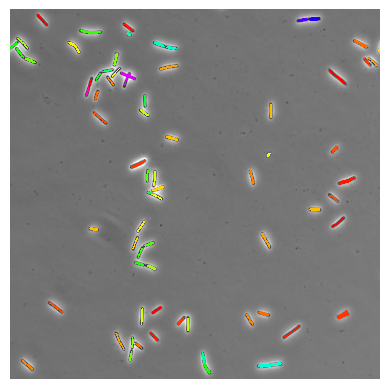

In [ ]:
colored_mask = np.ma.masked_where(quadmask==0, quadmask)

plt.imshow(img)
plt.imshow(colored_mask, cmap='hsv')
plt.axis('off')
plt.show

In [ ]:
values, counts = np.unique(quadmask, return_counts=True)
vc_dict = dict(sorted(zip(values, counts), key=lambda x: x[1], reverse=True))

In [ ]:
values[counts <= 200]

array([], dtype=int64)

In [ ]:
# !pip install ipywidgets

In [ ]:
import ipywidgets as widgets
from IPython.display import display

def DisplayMask(value):
  # create a binary mask where only pixels with selected value are shown
  single_mask = np.where(quadmask == value, 1, 0)

  count = vc_dict[value]

  plt.figure(figsize=(6,6))

  plt.imshow(img)

  # overlay mask with transparency
  plt.imshow(single_mask, cmap='cool', alpha = 0.5)
  plt.title(f"Mask Size: {count}")
  plt.axis('off')
  plt.show()



In [ ]:
dropdown = widgets.Dropdown(
    options=vc_dict.keys(),
    value=list(vc_dict.keys())[0],
    description="mask value:"
)

interactive_display = widgets.interactive(DisplayMask, value=dropdown)
display(interactive_display)



interactive(children=(Dropdown(description='mask value:', options=(0, 2, 1, 7, 3, 4, 6, 5, 8, 28, 19, 18, 9, 1…

### Rerun segmented image

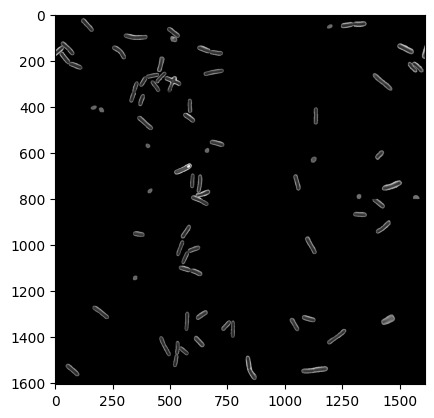

In [ ]:
img_2 = img.copy()
img_2[quadmask==0] = 0
plt.imshow(img_2)